## 8. 카메라 스티커앱 만들기 첫걸음

In [1]:
#module import 
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

### 1. Data Load

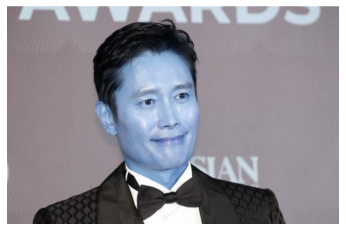

In [30]:
#image 
my_image_path = os.getenv('HOME')+'/aiffel/face_data/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.axis('off')
plt.show()

<br>
-  BGR을 RGB로 바꾸어보자!

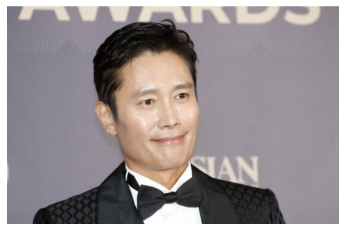

In [29]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

### 2. Face detect

In [4]:
#dlib의 hod detector를 통해 얼굴 검출
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(504, 290) (889, 675)]]


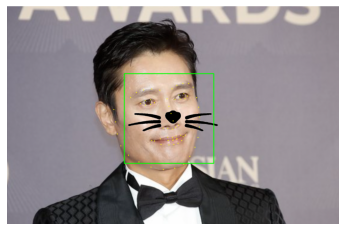

In [28]:
# Bounding box 확인
#Bounding box --> (top_left, bottom_right)
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.axis('off')
plt.show()

<br>

* Landmark 모델을 통해 얼굴에 landmark list를 만들어보자! 

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


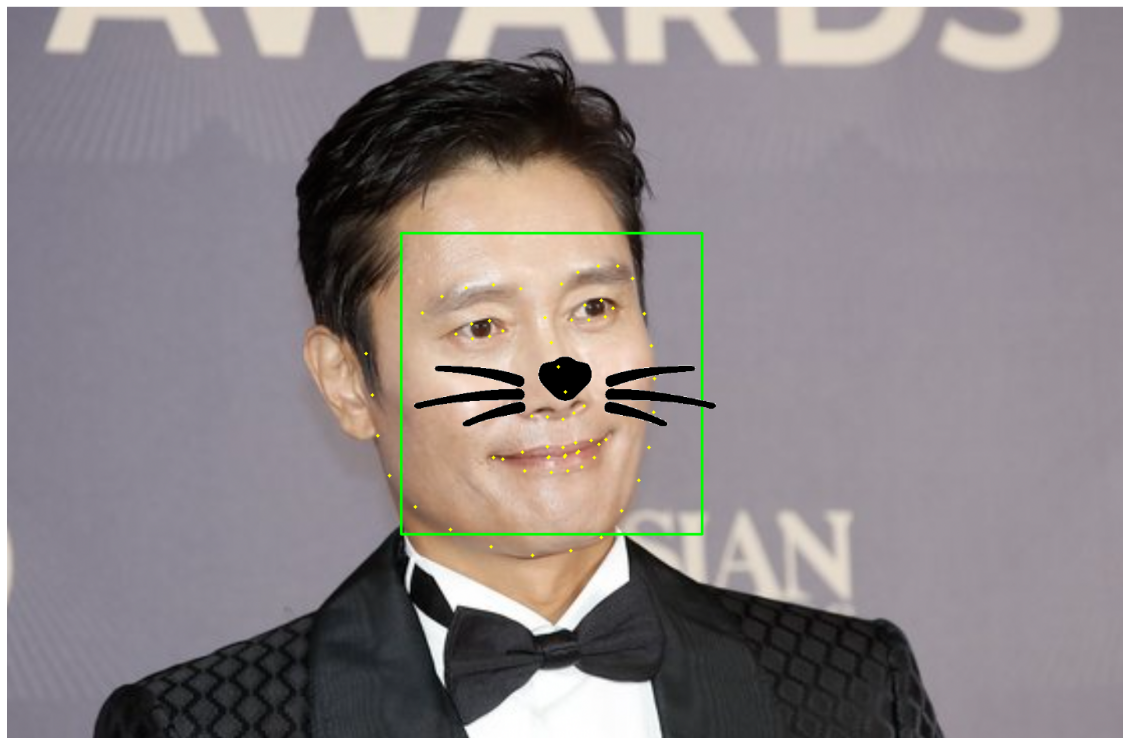

In [27]:
#잘찍혔나 확인!

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

plt.figure(figsize=(20,20))        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img_show_rgb)
plt.show()

### 3. 얼굴 기울기 구하기


In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(714, 493)
(x,y) : (714,300)
(w,h) : (386,386)


### 스티커를 붙여보자!

(386, 386, 3)


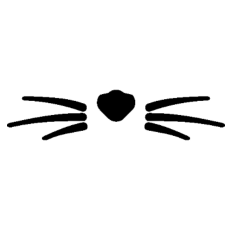

In [26]:
sticker_path = os.getenv('HOME')+'/aiffel/face_data/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
print (img_sticker.shape)

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/face_data/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(386, 386, 3)


In [12]:
#x,y를 통하여 코 위치를 설정!
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (521,107)


In [13]:
if refined_x < 0 and refined_y < 0 :
    img_sticker = img_sticker[-refined_y:][-refined_x:] # image sticker crop
    refined_y , refined_x = 0 , 0 

elif refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
elif refined_x < 0 :
    img_sticker = img_sticker[:][-refined_x:]
    refined_x = 0
    
else :
    pass

print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) 


(386, 386, 3)
(x,y) : (521,107)


In [14]:
#shape 확인
x_shape = img_sticker.shape[0]
y_shape = img_sticker.shape[1]
print('(x_shape,y_shape) : (%d,%d)'%(x_shape, y_shape))

(x_shape,y_shape) : (386,386)


In [15]:
#Sticker 적용!
sticker_area = img_show[y:y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[y:y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

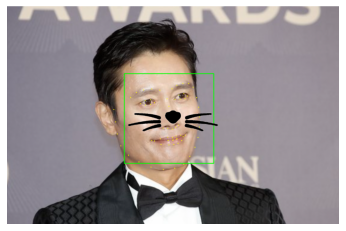

In [25]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

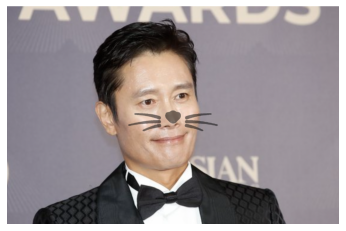

In [22]:
#img_bgr에 새롭게 스티커를 붙여보자!
#addweighted를 활용하여 투명도 조절과 함께 구성 

img_bgr_copy = img_bgr.copy() #img_bgr 원본 유지하기 위해서 copy

sticker_area = img_bgr_copy[y:y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]]
img_bgr_copy[y:y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 
plt.axis('off')

img_blended = cv2.addWeighted(img_bgr,0.5,img_bgr_copy,0.5,0) 
plt.imshow(cv2.cvtColor(img_blended, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 다른 다양한 이미지에도 적용

In [31]:
#위의 코드들을 함수화하여 적용해보기!

def test_sticker(img_path):
    
    #이미지 로드
    my_image_path = os.getenv('HOME')+'/aiffel/face_data/' + img_path
    img_bgr = cv2.imread(my_image_path)
    img_bgr = cv2.resize(img_bgr, (640, 360)) 
    img_show = img_bgr.copy()
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    detector_hog = dlib.get_frontal_face_detector() 

    #detector를 이용해 얼굴의 bounding box 추출
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1) 
    
    # 얼굴 검출
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)    
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)        
    
    #스티커 위치
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # whiskers center index : 33
        x = landmark[30][0]
        y = landmark[30][1] 
        w = h = dlib_rect.width()
    
    
    sticker_path = os.getenv('HOME')+'/aiffel/face_data/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    # top, left 위치 
    refined_x = x - w//2 # left
    refined_y = y - h//2   # top

    
    sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

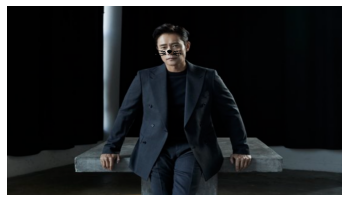

In [32]:
#정면 적용
test_sticker('image2.png')

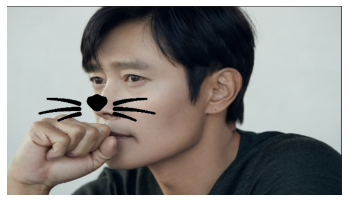

In [33]:
#측면 적용에서도 부분적으로 잘 동작하는 것으로 확인!
test_sticker('image3.png')

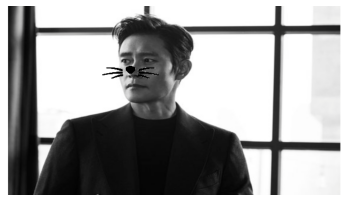

In [34]:
#흑백 적용
test_sticker('image4.png')

### 질문에 답해보며 정리해보자!

#### 1. 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

- 정면, 측면, 반-측면 등 얼굴 각도에 따라 부분적으로 얼굴 인식이 잘 작동하는 것을 확인할 수 있었지만, 측면의 경우 정확하게 작동한다고 말할수는 없었다. 측면의 경우 각도에 맞게 스티커를 회전해주는 작업이 필요하다.

#### 2. 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 비교적 거리가 있는 image2의 경우 잘 작동하였지만, 너무 멀다면 제대로 작동하지 않았다. landmark가 정확히 얼굴을 detect하지 못해 일어나는 현상같은데.. 이 부분은 아직 내 역량에서 벗어나는 것 같다..

#### 3. 실행 속도가 중요할까요?

- 실제 유저관점에서 해당 기능을 구현한다면 속도와 관련한 부분이 정말 중요할 수 밖에 없을 듯하다. 어떠한 작업을 통해 위 작업의 Process를 경량화, 효율화 시킬 수 있는가에 대한 부분 역시 잘 모르겠다. 

#### 4. 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

- 정확도가 '얼마나' 중요할까라는 고민은 딱히 의미가 있는 질문인지 아직 이해를 잘 못하겠다. 정확도야.. 높으면 높을 수록 좋은 것 아닐까..?

## 회고

1. 결론적으로, 수염 붙혔다 떼는 거 재미없다.

2. 그럼에도 궁금한 것은 실제 상용화된 서비스와 위의 코드가 어느 부분에서 '얼마만큼' 다른가?하는 지점이다.

3. 근데 BGR이 opencv에서 default가 된 이유가 뭘까? 어차피 변환해줄꺼... "그냥 RGB로 통합해주면 안되나?"라는 질문은 다음 링크로 해결되었다. (https://blog.xcoda.net/102)

4. 다른 익스 노드들 경우에는 이런 걸 배워야겠구나, 이런 지점을 해보면 재밌겠다라는 아이디어가 있었는데, 이번 익스는 '하라니까 하는' 수준의 작업이었다. CV 어렵다..

5. 다신 보지 말자.. 고양이 수염..